<a href="https://colab.research.google.com/github/vincenzobucciero/mySegmentAnything/blob/main/maskGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvidia-smi

Fri Feb 16 10:00:17 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [4]:
#install segment anything model
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [6]:
#install other dependencies
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision

# jupyter_bbox_widget: Una libreria Python per la visualizzazione interattiva delle bounding box.

# roboflow:  libreria per l'integrazione con Roboflow, una piattaforma per la gestione dei dati di computer vision.

# dataclasses-json: libreria Python che semplifica la serializzazione e la deserializzazione di oggetti dataclass in e da formati JSON.
#                   È utile quando si lavora con dati strutturati in applicazioni Python.

# supervision: libreria Python per la supervisione di modelli di machine learning.

In [7]:
# download SAM WEIGHTS
!mkdir -p {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P {HOME}/weights

In [8]:
import os

CHECKPOINT_PATH = os.path.join(HOME, "weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

/content/weights/sam_vit_h_4b8939.pth ; exist: True


In [9]:
# download example data
!mkdir -p {HOME}/data/imageTest
!mkdir -p {HOME}/data/videoTest
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg -P {HOME}/data/imageTest
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg -P {HOME}/data/imageTest
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg -P {HOME}/data/imageTest
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg -P {HOME}/data/imageTest

In [10]:
# load model
import torch

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

In [12]:
# automated mask generator
# To run automatic mask generation, provide a SAM model to the SamAutomaticMaskGenerator class. Set the path below to the SAM checkpoint
mask_generator = SamAutomaticMaskGenerator(sam)

import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data/imageTest", IMAGE_NAME)

# VIDEO_NAME = "videoSample1.mp4"
# VIDEO_PATH = os.path.join(HOME, "data/videoTest", VIDEO_NAME)

import cv2
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)


In [13]:
# output format
# SamAutomaticMaskGenerator returns a list of masks, where each mask is a dict containing various information about the mask:

#   segmentation - [np.ndarray] - the mask with (W, H) shape, and bool type
#   area - [int] - the area of the mask in pixels
#   bbox - [List[int]] - the boundary box of the mask in xywh format
#   predicted_iou - [float] - the model's own prediction for the quality of the mask
#   point_coords - [List[List[float]]] - the sampled input point that generated this mask
#   stability_score - [float] - an additional measure of mask quality
#   crop_box - List[int] - the crop of the image used to generate this mask in xywh format

print(sam_result[0].keys())

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


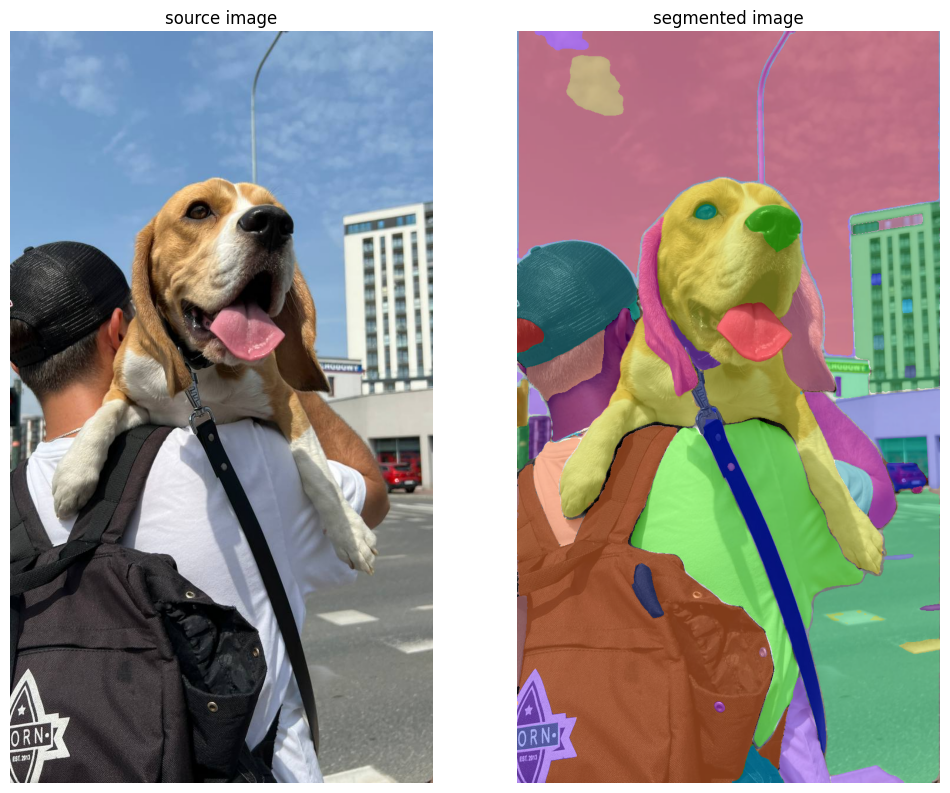

In [14]:
# Results visualisation with Supervision

mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections.from_sam(sam_result=sam_result)

annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)

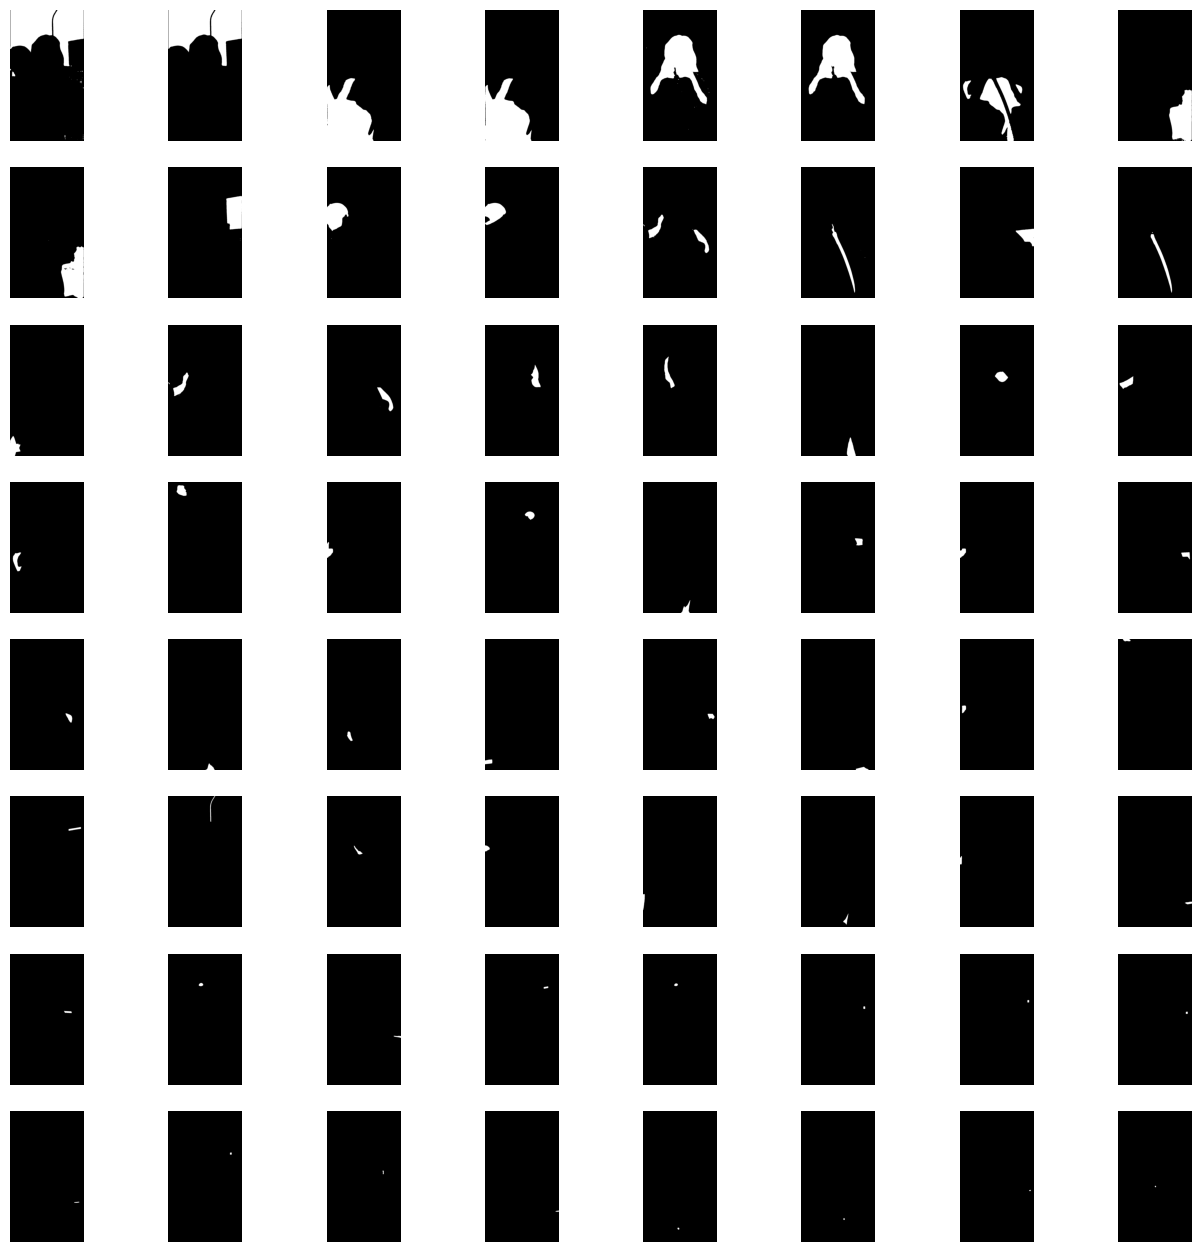

In [15]:
# print all masks

masks = [
    mask['segmentation']
    for mask
    in sorted(sam_result, key=lambda x: x['area'], reverse=True)
]

sv.plot_images_grid(
    images=masks,
    grid_size=(8, int(len(masks) / 8)),
    size=(16, 16)
)

In [17]:
# other type of segmentation

# BOUNDING BOX

mask_predictor = SamPredictor(sam)

import os

IMAGE_NAME = "dog.jpeg"
IMAGE_PATH = os.path.join(HOME, "data/imageTest", IMAGE_NAME)

# drow BOX

import base64

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

# if using colab
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [18]:
#  print BOUNDIX BOX

widget.bboxes

[{'x': 237, 'y': 370, 'width': 318, 'height': 241, 'label': ''}]

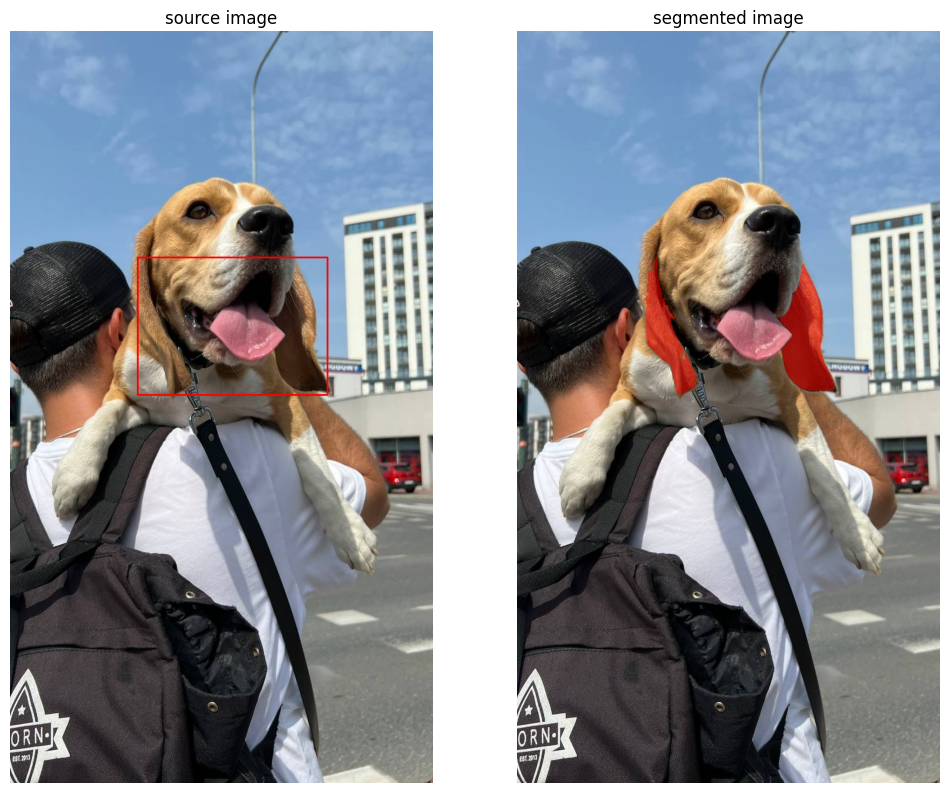

In [19]:
# SamPredictor.predict method takes np.ndarray box argument in [x_min, y_min, x_max, y_max] format. Let's reorganise your data first

import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = np.array([
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
])


import cv2
import numpy as np
import supervision as sv

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True
)

box_annotator = sv.BoxAnnotator(color=sv.Color.RED)
mask_annotator = sv.MaskAnnotator(color=sv.Color.RED, color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
    xyxy=sv.mask_to_xyxy(masks=masks),
    mask=masks
)
detections = detections[detections.area == np.max(detections.area)]

source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)